# Growth vs Value Factor Analysis Using Fundamentals Only
## Statistical Study of Indian Stock Market (Cross-Sectional Analysis)

### Alternative Approach: Using ONLY the Fundamentals Dataset
- **Growth Factor:** Earnings Quarterly Growth
- **Value Factor:** P/E Ratio (low P/E = value)
- **Outcome:** Price Volatility & Cross-sectional Returns

### Course Mapping:
- **Lectures 1-9:** Data organization, visualization, descriptive stats
- **Lectures 10-18:** Probability distributions, random variables
- **Lectures 19-28:** Hypothesis testing, statistical inference

### Advantages of This Approach:
✅ Simpler - only one dataset needed
✅ More stocks (~1,100 vs 122)
✅ All data from same source/time
✅ No complex merging required

## Story 1.1: Setup and Import Libraries (10 mins)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"Python environment ready for Growth vs Value analysis")

✅ Libraries imported successfully!
Python environment ready for Growth vs Value analysis


## Story 1.2: Load and Explore the Fundamentals Dataset (15 mins)

In [2]:
# Load the fundamentals dataset
fundamentals = pd.read_csv('Datasets/FUNDAMENTALratios.csv')

print("📊 DATASET OVERVIEW")
print("="*60)
print(f"Shape: {fundamentals.shape}")
print(f"\nColumns ({len(fundamentals.columns)} total):")
print(fundamentals.columns.tolist())

print("\n📈 Sample Data (First 5 rows):")
print(fundamentals.head())

# Check data types
print("\n🔍 Data Types:")
print(fundamentals.dtypes)

📊 DATASET OVERVIEW
Shape: (5910, 18)

Columns (18 total):
['symbol', 'revenuePerShare', 'trailingPE', 'earningsQuarterlyGrowth', 'previousClose', 'open', 'dayLow', 'dayHigh', 'volume', 'trailingEps', 'pegRatio', 'ebitda', 'totalDebt', 'totalRevenue', 'debtToEquity', 'revenuePerShare.1', 'earningsGrowth', 'revenueGrowth']

📈 Sample Data (First 5 rows):
          symbol  revenuePerShare  trailingPE  earningsQuarterlyGrowth  \
0    RELIANCE.BO         1296.823   28.012129                    0.093   
1    RELIANCE.NS         1296.823   28.010878                    0.093   
2    HDFCBANK.BO          293.740   16.260424                    0.359   
3  HINDUNILVR.NS          263.412   51.285230                    0.014   
4   ICICIBANK.NS          197.399   18.315136                    0.257   

   previousClose     open   dayLow  dayHigh      volume  trailingEps  \
0        2901.30  2897.05  2895.35   2920.0    562484.0       103.88   
1        2901.95  2899.95  2894.70   2920.0   9763420.0  

In [3]:
# Explore key metrics for our analysis
print("🎯 KEY METRICS FOR ANALYSIS")
print("="*60)

# Growth metrics
print("\n📈 GROWTH METRICS:")
growth_cols = ['earningsQuarterlyGrowth', 'earningsGrowth', 'revenueGrowth']
for col in growth_cols:
    non_null = fundamentals[col].notna().sum()
    print(f"  {col}: {non_null}/{len(fundamentals)} non-null values")

# Value metrics
print("\n💰 VALUE METRICS:")
value_cols = ['trailingPE', 'pegRatio', 'debtToEquity']
for col in value_cols:
    non_null = fundamentals[col].notna().sum()
    print(f"  {col}: {non_null}/{len(fundamentals)} non-null values")

# Price data
print("\n📊 PRICE DATA (for volatility):")
price_cols = ['previousClose', 'open', 'dayLow', 'dayHigh', 'volume']
for col in price_cols:
    non_null = fundamentals[col].notna().sum()
    print(f"  {col}: {non_null}/{len(fundamentals)} non-null values")

🎯 KEY METRICS FOR ANALYSIS

📈 GROWTH METRICS:
  earningsQuarterlyGrowth: 2326/5910 non-null values
  earningsGrowth: 2288/5910 non-null values
  revenueGrowth: 3171/5910 non-null values

💰 VALUE METRICS:
  trailingPE: 3382/5910 non-null values
  pegRatio: 353/5910 non-null values
  debtToEquity: 2740/5910 non-null values

📊 PRICE DATA (for volatility):
  previousClose: 5330/5910 non-null values
  open: 5332/5910 non-null values
  dayLow: 5332/5910 non-null values
  dayHigh: 5332/5910 non-null values
  volume: 5332/5910 non-null values


## Story 1.3: Data Cleaning and Preparation (20 mins)
Clean the data and prepare for analysis

In [4]:
# Create a clean copy for analysis
df = fundamentals.copy()

# Clean stock symbols (remove .NS and .BO suffixes)
df['stock'] = df['symbol'].str.replace(r'\.(NS|BO)$', '', regex=True)

print("🧹 DATA CLEANING PROCESS")
print("="*60)

# Step 1: Remove duplicates (keep first occurrence of each stock)
print(f"\n1. Removing duplicates...")
print(f"   Before: {len(df)} rows")
df = df.drop_duplicates(subset=['stock'], keep='first')
print(f"   After: {len(df)} rows")
print(f"   Unique stocks: {df['stock'].nunique()}")

# Step 2: Convert string columns to numeric
print(f"\n2. Converting to numeric types...")
numeric_cols = ['trailingPE', 'earningsQuarterlyGrowth', 'earningsGrowth', 
                'revenueGrowth', 'previousClose', 'open', 'dayLow', 'dayHigh',
                'volume', 'debtToEquity', 'pegRatio']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 3: Calculate additional metrics
print(f"\n3. Calculating additional metrics...")

# Daily volatility (normalized by price)
df['daily_volatility'] = (df['dayHigh'] - df['dayLow']) / df['previousClose']
print(f"   ✅ Calculated daily volatility")

# Daily return (open to close proxy)
df['daily_return'] = (df['previousClose'] - df['open']) / df['open']
print(f"   ✅ Calculated daily return")

# Price-to-earnings groups
df['pe_valid'] = (df['trailingPE'] > 0) & (df['trailingPE'] < 100)
print(f"   ✅ Identified valid P/E ratios")

print(f"\n📊 Data shape after cleaning: {df.shape}")

🧹 DATA CLEANING PROCESS

1. Removing duplicates...
   Before: 5910 rows
   After: 4207 rows
   Unique stocks: 4207

2. Converting to numeric types...

3. Calculating additional metrics...
   ✅ Calculated daily volatility
   ✅ Calculated daily return
   ✅ Identified valid P/E ratios

📊 Data shape after cleaning: (4207, 22)


In [5]:
# Filter to stocks with valid data for analysis
print("🎯 SELECTING STOCKS FOR ANALYSIS")
print("="*60)

# Define our analysis dataset with required criteria
analysis_df = df[
    # Must have valid P/E ratio (value metric)
    (df['trailingPE'] > 0) & 
    (df['trailingPE'] < 100) &
    # Must have earnings growth data (growth metric)
    (df['earningsQuarterlyGrowth'].notna()) &
    # Must have price data
    (df['previousClose'] > 0) &
    (df['daily_volatility'].notna()) &
    # Remove extreme outliers in growth
    (df['earningsQuarterlyGrowth'] > -5) &
    (df['earningsQuarterlyGrowth'] < 5)
].copy()

# Select relevant columns
analysis_df = analysis_df[[
    'stock', 'trailingPE', 'earningsQuarterlyGrowth', 'earningsGrowth',
    'revenueGrowth', 'previousClose', 'daily_volatility', 'daily_return',
    'volume', 'debtToEquity'
]]

# Rename for clarity
analysis_df.columns = ['Stock', 'PE_Ratio', 'Earnings_Growth_Q', 'Earnings_Growth_Y',
                       'Revenue_Growth', 'Price', 'Volatility', 'Daily_Return',
                       'Volume', 'Debt_to_Equity']

print(f"✅ Final dataset for analysis: {len(analysis_df)} stocks")
print(f"\n📋 Summary of key variables:")
print(analysis_df[['PE_Ratio', 'Earnings_Growth_Q', 'Volatility']].describe())

# Show sample
print(f"\n🔍 Sample of analysis data:")
print(analysis_df.head(10))

🎯 SELECTING STOCKS FOR ANALYSIS
✅ Final dataset for analysis: 1102 stocks

📋 Summary of key variables:
          PE_Ratio  Earnings_Growth_Q   Volatility
count  1102.000000        1102.000000  1102.000000
mean     31.803468           0.345529     0.038239
std      20.612529           0.842330     0.023875
min       0.495208          -0.985000     0.000000
25%      15.972013          -0.119000     0.022984
50%      26.483036           0.182500     0.032437
75%      43.839875           0.585500     0.046731
max      99.995380           4.794000     0.199878

🔍 Sample of analysis data:
         Stock   PE_Ratio  Earnings_Growth_Q  Earnings_Growth_Y  \
0     RELIANCE  28.012129              0.093              0.093   
2     HDFCBANK  16.260424              0.359             -0.001   
3   HINDUNILVR  51.285230              0.014              0.014   
4    ICICIBANK  18.315136              0.257              0.253   
6         INFY  25.573729             -0.084             -0.068   
7       

## Story 1.4: Exploratory Data Analysis (Lec 1-9) (15 mins)
Visualize distributions and relationships

📊 EXPLORATORY DATA ANALYSIS (Applying Lectures 1-9)


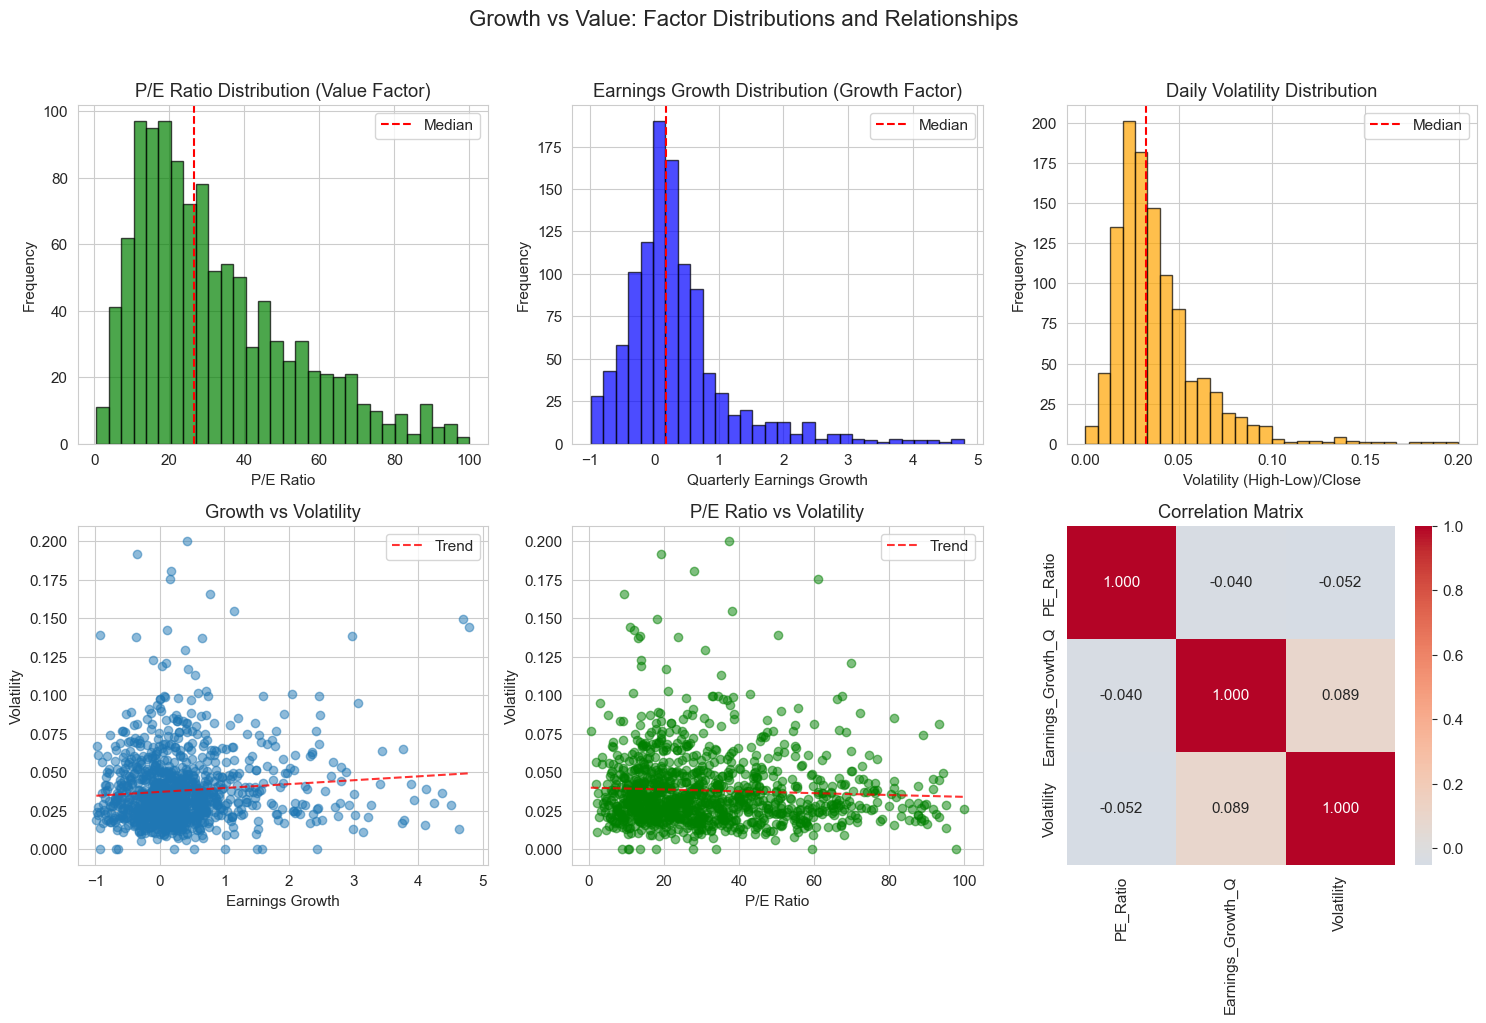


🔍 KEY CORRELATIONS:
Growth vs Volatility: 0.089
P/E vs Volatility: -0.052
Growth vs P/E: -0.040


In [6]:
# Create comprehensive EDA visualizations
print("📊 EXPLORATORY DATA ANALYSIS (Applying Lectures 1-9)")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Growth vs Value: Factor Distributions and Relationships', fontsize=16, y=1.02)

# 1. P/E Ratio Distribution (Value Factor)
axes[0, 0].hist(analysis_df['PE_Ratio'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 0].axvline(analysis_df['PE_Ratio'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].set_title('P/E Ratio Distribution (Value Factor)')
axes[0, 0].set_xlabel('P/E Ratio')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# 2. Earnings Growth Distribution (Growth Factor)
axes[0, 1].hist(analysis_df['Earnings_Growth_Q'], bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].axvline(analysis_df['Earnings_Growth_Q'].median(), color='red', linestyle='--', label='Median')
axes[0, 1].set_title('Earnings Growth Distribution (Growth Factor)')
axes[0, 1].set_xlabel('Quarterly Earnings Growth')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Volatility Distribution (Outcome Variable)
axes[0, 2].hist(analysis_df['Volatility'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].axvline(analysis_df['Volatility'].median(), color='red', linestyle='--', label='Median')
axes[0, 2].set_title('Daily Volatility Distribution')
axes[0, 2].set_xlabel('Volatility (High-Low)/Close')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# 4. Growth vs Volatility
axes[1, 0].scatter(analysis_df['Earnings_Growth_Q'], analysis_df['Volatility'], alpha=0.5)
axes[1, 0].set_title('Growth vs Volatility')
axes[1, 0].set_xlabel('Earnings Growth')
axes[1, 0].set_ylabel('Volatility')
# Add trend line
z = np.polyfit(analysis_df['Earnings_Growth_Q'].dropna(), 
               analysis_df.loc[analysis_df['Earnings_Growth_Q'].notna(), 'Volatility'], 1)
p = np.poly1d(z)
x_trend = np.linspace(analysis_df['Earnings_Growth_Q'].min(), 
                     analysis_df['Earnings_Growth_Q'].max(), 100)
axes[1, 0].plot(x_trend, p(x_trend), "r--", alpha=0.8, label='Trend')
axes[1, 0].legend()

# 5. Value (P/E) vs Volatility
axes[1, 1].scatter(analysis_df['PE_Ratio'], analysis_df['Volatility'], alpha=0.5, color='green')
axes[1, 1].set_title('P/E Ratio vs Volatility')
axes[1, 1].set_xlabel('P/E Ratio')
axes[1, 1].set_ylabel('Volatility')
# Add trend line
z = np.polyfit(analysis_df['PE_Ratio'], analysis_df['Volatility'], 1)
p = np.poly1d(z)
x_trend = np.linspace(analysis_df['PE_Ratio'].min(), analysis_df['PE_Ratio'].max(), 100)
axes[1, 1].plot(x_trend, p(x_trend), "r--", alpha=0.8, label='Trend')
axes[1, 1].legend()

# 6. Correlation Heatmap
corr_data = analysis_df[['PE_Ratio', 'Earnings_Growth_Q', 'Volatility']].dropna()
corr_matrix = corr_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, ax=axes[1, 2])
axes[1, 2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Print correlation insights
print("\n🔍 KEY CORRELATIONS:")
print(f"Growth vs Volatility: {corr_matrix.loc['Earnings_Growth_Q', 'Volatility']:.3f}")
print(f"P/E vs Volatility: {corr_matrix.loc['PE_Ratio', 'Volatility']:.3f}")
print(f"Growth vs P/E: {corr_matrix.loc['Earnings_Growth_Q', 'PE_Ratio']:.3f}")

## Story 1.5: Probability Modeling (Lec 10-18) (15 mins)
Model factors as random variables and test distributions

In [7]:
print("🎲 PROBABILITY MODELING (Applying Lectures 10-18)")
print("="*60)

# Treat each factor as a random variable
growth_rv = analysis_df['Earnings_Growth_Q'].dropna()
value_rv = analysis_df['PE_Ratio'].dropna()
volatility_rv = analysis_df['Volatility'].dropna()

print("📊 RANDOM VARIABLE STATISTICS:")
print("\n1. Growth Factor (Earnings Growth):")
print(f"   Expected Value E[G]: {growth_rv.mean():.4f}")
print(f"   Variance Var(G): {growth_rv.var():.4f}")
print(f"   Standard Deviation σ(G): {growth_rv.std():.4f}")
print(f"   Skewness: {stats.skew(growth_rv):.4f}")
print(f"   Kurtosis: {stats.kurtosis(growth_rv):.4f}")

print("\n2. Value Factor (P/E Ratio):")
print(f"   Expected Value E[V]: {value_rv.mean():.4f}")
print(f"   Variance Var(V): {value_rv.var():.4f}")
print(f"   Standard Deviation σ(V): {value_rv.std():.4f}")
print(f"   Skewness: {stats.skew(value_rv):.4f}")
print(f"   Kurtosis: {stats.kurtosis(value_rv):.4f}")

print("\n3. Outcome (Volatility):")
print(f"   Expected Value E[Vol]: {volatility_rv.mean():.4f}")
print(f"   Variance Var(Vol): {volatility_rv.var():.4f}")
print(f"   Standard Deviation σ(Vol): {volatility_rv.std():.4f}")
print(f"   Skewness: {stats.skew(volatility_rv):.4f}")
print(f"   Kurtosis: {stats.kurtosis(volatility_rv):.4f}")

🎲 PROBABILITY MODELING (Applying Lectures 10-18)
📊 RANDOM VARIABLE STATISTICS:

1. Growth Factor (Earnings Growth):
   Expected Value E[G]: 0.3455
   Variance Var(G): 0.7095
   Standard Deviation σ(G): 0.8423
   Skewness: 1.9587
   Kurtosis: 5.5538

2. Value Factor (P/E Ratio):
   Expected Value E[V]: 31.8035
   Variance Var(V): 424.8763
   Standard Deviation σ(V): 20.6125
   Skewness: 0.9900
   Kurtosis: 0.4009

3. Outcome (Volatility):
   Expected Value E[Vol]: 0.0382
   Variance Var(Vol): 0.0006
   Standard Deviation σ(Vol): 0.0239
   Skewness: 2.2492
   Kurtosis: 8.3121


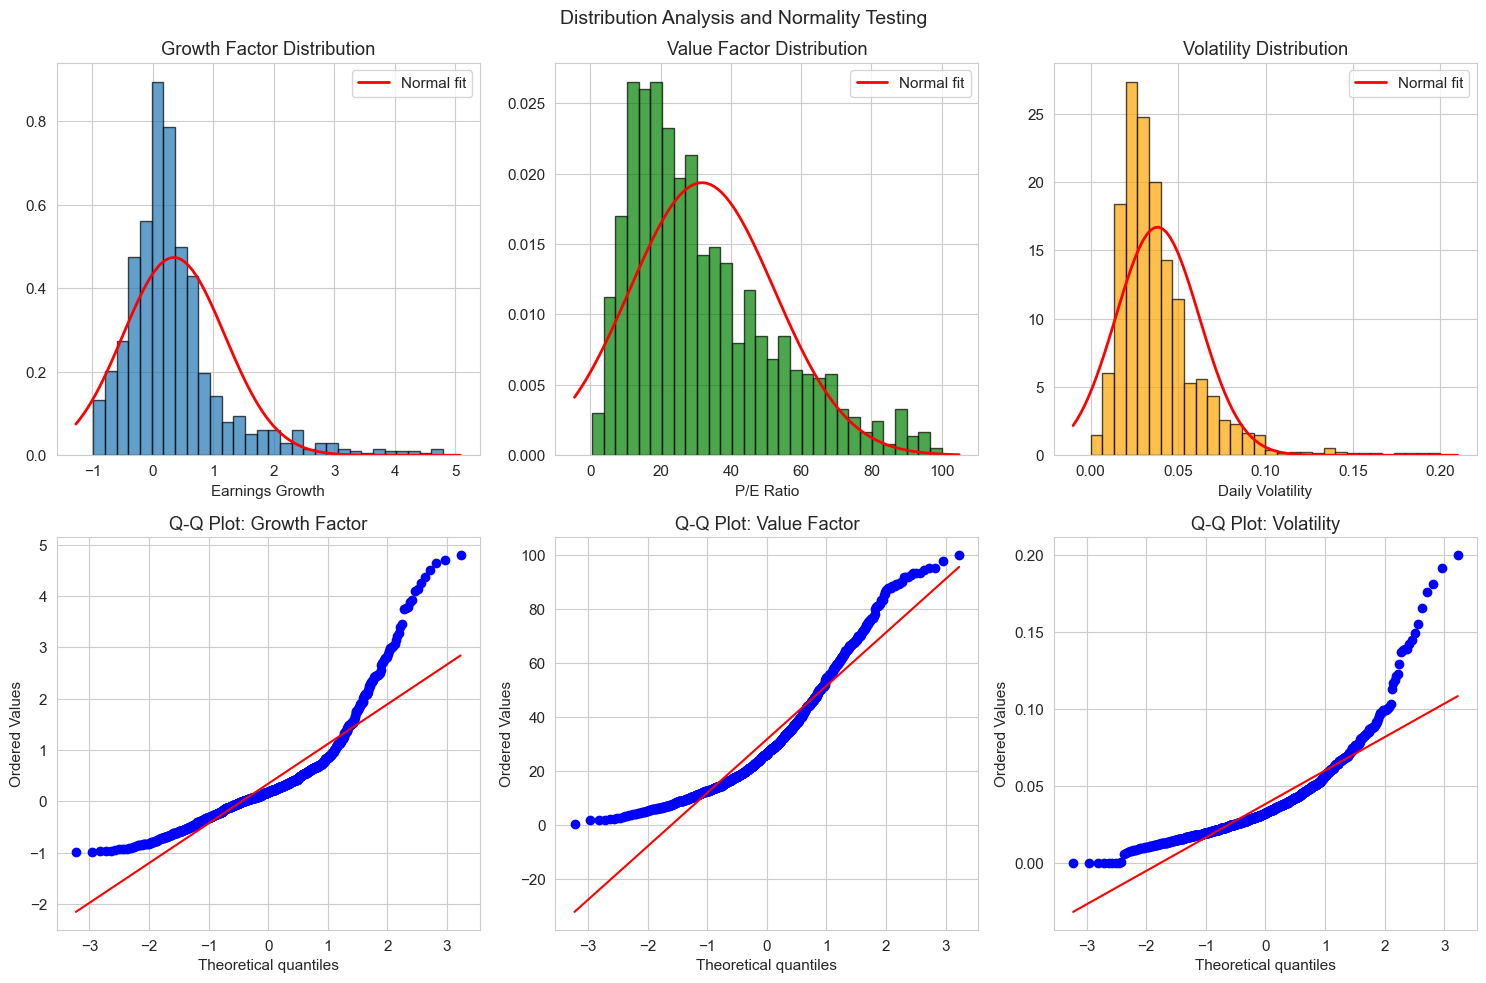


📈 NORMALITY TESTS (Shapiro-Wilk):

Growth:
  Test statistic: 0.8405
  P-value: 0.0000
  Result: Reject normality at 5% level

Value:
  Test statistic: 0.9176
  P-value: 0.0000
  Result: Reject normality at 5% level

Volatility:
  Test statistic: 0.8259
  P-value: 0.0000
  Result: Reject normality at 5% level


In [8]:
# Test for normality and visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution Analysis and Normality Testing', fontsize=14)

# Growth Factor
axes[0, 0].hist(growth_rv, bins=30, density=True, alpha=0.7, edgecolor='black')
mu, std = growth_rv.mean(), growth_rv.std()
xmin, xmax = axes[0, 0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
axes[0, 0].plot(x, p, 'r-', linewidth=2, label='Normal fit')
axes[0, 0].set_title('Growth Factor Distribution')
axes[0, 0].set_xlabel('Earnings Growth')
axes[0, 0].legend()

# Value Factor
axes[0, 1].hist(value_rv, bins=30, density=True, alpha=0.7, edgecolor='black', color='green')
mu, std = value_rv.mean(), value_rv.std()
xmin, xmax = axes[0, 1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
axes[0, 1].plot(x, p, 'r-', linewidth=2, label='Normal fit')
axes[0, 1].set_title('Value Factor Distribution')
axes[0, 1].set_xlabel('P/E Ratio')
axes[0, 1].legend()

# Volatility
axes[0, 2].hist(volatility_rv, bins=30, density=True, alpha=0.7, edgecolor='black', color='orange')
mu, std = volatility_rv.mean(), volatility_rv.std()
xmin, xmax = axes[0, 2].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
axes[0, 2].plot(x, p, 'r-', linewidth=2, label='Normal fit')
axes[0, 2].set_title('Volatility Distribution')
axes[0, 2].set_xlabel('Daily Volatility')
axes[0, 2].legend()

# Q-Q Plots
stats.probplot(growth_rv, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Growth Factor')

stats.probplot(value_rv, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Value Factor')

stats.probplot(volatility_rv, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot: Volatility')

plt.tight_layout()
plt.show()

# Normality tests
print("\n📈 NORMALITY TESTS (Shapiro-Wilk):")
for name, data in [('Growth', growth_rv), ('Value', value_rv), ('Volatility', volatility_rv)]:
    stat, p_value = stats.shapiro(data[:5000])  # Shapiro-Wilk limited to 5000 samples
    print(f"\n{name}:")
    print(f"  Test statistic: {stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Result: {'Reject normality' if p_value < 0.05 else 'Cannot reject normality'} at 5% level")

## Story 1.6: Portfolio Construction (20 mins)
Create quintile portfolios based on growth and value factors

In [9]:
print("📦 PORTFOLIO CONSTRUCTION (Sampling Theory Application)")
print("="*60)

# Create quintile portfolios
analysis_df['Growth_Quintile'] = pd.qcut(analysis_df['Earnings_Growth_Q'], 
                                         q=5, 
                                         labels=['Q1_Low_Growth', 'Q2', 'Q3', 'Q4', 'Q5_High_Growth'])

analysis_df['Value_Quintile'] = pd.qcut(analysis_df['PE_Ratio'], 
                                        q=5, 
                                        labels=['Q1_Value', 'Q2', 'Q3', 'Q4', 'Q5_Growth'])

print(f"Total stocks divided into 5 quintiles of ~{len(analysis_df)//5} stocks each\n")

# Show quintile boundaries
print("📊 GROWTH QUINTILE BOUNDARIES:")
growth_boundaries = analysis_df.groupby('Growth_Quintile')['Earnings_Growth_Q'].agg(['min', 'max', 'mean', 'count'])
print(growth_boundaries)

print("\n💰 VALUE QUINTILE BOUNDARIES (P/E):")
value_boundaries = analysis_df.groupby('Value_Quintile')['PE_Ratio'].agg(['min', 'max', 'mean', 'count'])
print(value_boundaries)

📦 PORTFOLIO CONSTRUCTION (Sampling Theory Application)
Total stocks divided into 5 quintiles of ~220 stocks each

📊 GROWTH QUINTILE BOUNDARIES:
                   min    max      mean  count
Growth_Quintile                               
Q1_Low_Growth   -0.985 -0.233 -0.510824    221
Q2              -0.231  0.067 -0.057259    220
Q3               0.068  0.301  0.183250    220
Q4               0.304  0.694  0.484045    220
Q5_High_Growth   0.695  4.794  1.626502    221

💰 VALUE QUINTILE BOUNDARIES (P/E):
                      min        max       mean  count
Value_Quintile                                        
Q1_Value         0.495208  14.047131   9.698176    221
Q2              14.052287  21.646488  17.807814    220
Q3              21.727257  31.851050  26.639862    220
Q4              31.935482  48.309895  39.266753    220
Q5_Growth       48.321030  99.995380  65.551814    221


In [10]:
# Calculate portfolio performance (using volatility as outcome)
print("📈 PORTFOLIO PERFORMANCE ANALYSIS")
print("="*60)

# Growth portfolios
growth_performance = analysis_df.groupby('Growth_Quintile')['Volatility'].agg([
    'mean', 'std', 'count', 'median'
]).round(4)
growth_performance['std_error'] = growth_performance['std'] / np.sqrt(growth_performance['count'])

print("\n🚀 GROWTH PORTFOLIO VOLATILITY:")
print(growth_performance)

# Value portfolios  
value_performance = analysis_df.groupby('Value_Quintile')['Volatility'].agg([
    'mean', 'std', 'count', 'median'
]).round(4)
value_performance['std_error'] = value_performance['std'] / np.sqrt(value_performance['count'])

print("\n💎 VALUE PORTFOLIO VOLATILITY:")
print(value_performance)

# Calculate spreads
growth_spread = growth_performance.loc['Q5_High_Growth', 'mean'] - growth_performance.loc['Q1_Low_Growth', 'mean']
value_spread = value_performance.loc['Q1_Value', 'mean'] - value_performance.loc['Q5_Growth', 'mean']

print("\n📊 FACTOR SPREADS:")
print(f"Growth factor spread (Q5-Q1): {growth_spread:.4f}")
print(f"Value factor spread (Q1-Q5): {value_spread:.4f}")

📈 PORTFOLIO PERFORMANCE ANALYSIS

🚀 GROWTH PORTFOLIO VOLATILITY:
                   mean     std  count  median  std_error
Growth_Quintile                                          
Q1_Low_Growth    0.0379  0.0230    221  0.0331   0.001547
Q2               0.0371  0.0205    220  0.0319   0.001382
Q3               0.0355  0.0246    220  0.0287   0.001659
Q4               0.0375  0.0240    220  0.0321   0.001618
Q5_High_Growth   0.0431  0.0264    221  0.0373   0.001776

💎 VALUE PORTFOLIO VOLATILITY:
                  mean     std  count  median  std_error
Value_Quintile                                          
Q1_Value        0.0392  0.0254    221  0.0339   0.001709
Q2              0.0395  0.0232    220  0.0341   0.001564
Q3              0.0376  0.0231    220  0.0324   0.001557
Q4              0.0390  0.0250    220  0.0328   0.001685
Q5_Growth       0.0359  0.0226    221  0.0293   0.001520

📊 FACTOR SPREADS:
Growth factor spread (Q5-Q1): 0.0052
Value factor spread (Q1-Q5): 0.0033


## Story 1.7: Hypothesis Testing (Lec 19-28) (20 mins)
Test if growth and value factors significantly affect volatility

In [11]:
print("🔬 HYPOTHESIS TESTING FRAMEWORK (Lectures 19-28)")
print("="*70)

# Extract extreme quintiles for testing
high_growth = analysis_df[analysis_df['Growth_Quintile'] == 'Q5_High_Growth']['Volatility']
low_growth = analysis_df[analysis_df['Growth_Quintile'] == 'Q1_Low_Growth']['Volatility']
value_stocks = analysis_df[analysis_df['Value_Quintile'] == 'Q1_Value']['Volatility']
growth_stocks = analysis_df[analysis_df['Value_Quintile'] == 'Q5_Growth']['Volatility']

print("="*70)
print("TEST 1: GROWTH FACTOR ANALYSIS")
print("="*70)
print("\n📝 Hypotheses:")
print("H₀: μ(High Growth) = μ(Low Growth) [Growth doesn't affect volatility]")
print("H₁: μ(High Growth) ≠ μ(Low Growth) [Growth affects volatility]")

print("\n📊 Sample Statistics:")
print(f"High Growth (Q5): n={len(high_growth)}, mean={high_growth.mean():.4f}, std={high_growth.std():.4f}")
print(f"Low Growth (Q1):  n={len(low_growth)}, mean={low_growth.mean():.4f}, std={low_growth.std():.4f}")

# Two-sample t-test
t_stat_growth, p_value_growth = stats.ttest_ind(high_growth, low_growth)

print(f"\n📈 Test Results:")
print(f"T-statistic: {t_stat_growth:.4f}")
print(f"P-value: {p_value_growth:.6f}")
print(f"Effect size (Cohen's d): {(high_growth.mean() - low_growth.mean()) / np.sqrt((high_growth.var() + low_growth.var())/2):.4f}")

# Confidence interval for difference
se_diff = np.sqrt(high_growth.var()/len(high_growth) + low_growth.var()/len(low_growth))
ci_95 = stats.t.interval(0.95, len(high_growth)+len(low_growth)-2, 
                          loc=growth_spread, scale=se_diff)
print(f"95% CI for difference: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")

print(f"\n✅ Decision at α=0.05: {'REJECT H₀' if p_value_growth < 0.05 else 'FAIL TO REJECT H₀'}")
if p_value_growth < 0.05:
    print("   → Growth factor SIGNIFICANTLY affects volatility")
else:
    print("   → No significant evidence that growth affects volatility")

🔬 HYPOTHESIS TESTING FRAMEWORK (Lectures 19-28)
TEST 1: GROWTH FACTOR ANALYSIS

📝 Hypotheses:
H₀: μ(High Growth) = μ(Low Growth) [Growth doesn't affect volatility]
H₁: μ(High Growth) ≠ μ(Low Growth) [Growth affects volatility]

📊 Sample Statistics:
High Growth (Q5): n=221, mean=0.0431, std=0.0264
Low Growth (Q1):  n=221, mean=0.0379, std=0.0230

📈 Test Results:
T-statistic: 2.1861
P-value: 0.029337
Effect size (Cohen's d): 0.2080
95% CI for difference: [0.0006, 0.0098]

✅ Decision at α=0.05: REJECT H₀
   → Growth factor SIGNIFICANTLY affects volatility


In [12]:
print("="*70)
print("TEST 2: VALUE FACTOR ANALYSIS")
print("="*70)
print("\n📝 Hypotheses:")
print("H₀: μ(Value stocks) = μ(Growth stocks) [P/E doesn't affect volatility]")
print("H₁: μ(Value stocks) ≠ μ(Growth stocks) [P/E affects volatility]")

print("\n📊 Sample Statistics:")
print(f"Value Stocks (Q1): n={len(value_stocks)}, mean={value_stocks.mean():.4f}, std={value_stocks.std():.4f}")
print(f"Growth Stocks (Q5): n={len(growth_stocks)}, mean={growth_stocks.mean():.4f}, std={growth_stocks.std():.4f}")

# Two-sample t-test
t_stat_value, p_value_value = stats.ttest_ind(value_stocks, growth_stocks)

print(f"\n📈 Test Results:")
print(f"T-statistic: {t_stat_value:.4f}")
print(f"P-value: {p_value_value:.6f}")
print(f"Effect size (Cohen's d): {(value_stocks.mean() - growth_stocks.mean()) / np.sqrt((value_stocks.var() + growth_stocks.var())/2):.4f}")

# Confidence interval
se_diff_val = np.sqrt(value_stocks.var()/len(value_stocks) + growth_stocks.var()/len(growth_stocks))
ci_95_val = stats.t.interval(0.95, len(value_stocks)+len(growth_stocks)-2, 
                              loc=value_spread, scale=se_diff_val)
print(f"95% CI for difference: [{ci_95_val[0]:.4f}, {ci_95_val[1]:.4f}]")

print(f"\n✅ Decision at α=0.05: {'REJECT H₀' if p_value_value < 0.05 else 'FAIL TO REJECT H₀'}")
if p_value_value < 0.05:
    print("   → Value factor SIGNIFICANTLY affects volatility")
else:
    print("   → No significant evidence that P/E affects volatility")

TEST 2: VALUE FACTOR ANALYSIS

📝 Hypotheses:
H₀: μ(Value stocks) = μ(Growth stocks) [P/E doesn't affect volatility]
H₁: μ(Value stocks) ≠ μ(Growth stocks) [P/E affects volatility]

📊 Sample Statistics:
Value Stocks (Q1): n=221, mean=0.0392, std=0.0254
Growth Stocks (Q5): n=221, mean=0.0359, std=0.0226

📈 Test Results:
T-statistic: 1.4457
P-value: 0.148966
Effect size (Cohen's d): 0.1375
95% CI for difference: [-0.0012, 0.0078]

✅ Decision at α=0.05: FAIL TO REJECT H₀
   → No significant evidence that P/E affects volatility


## Story 1.8: Results Visualization (15 mins)

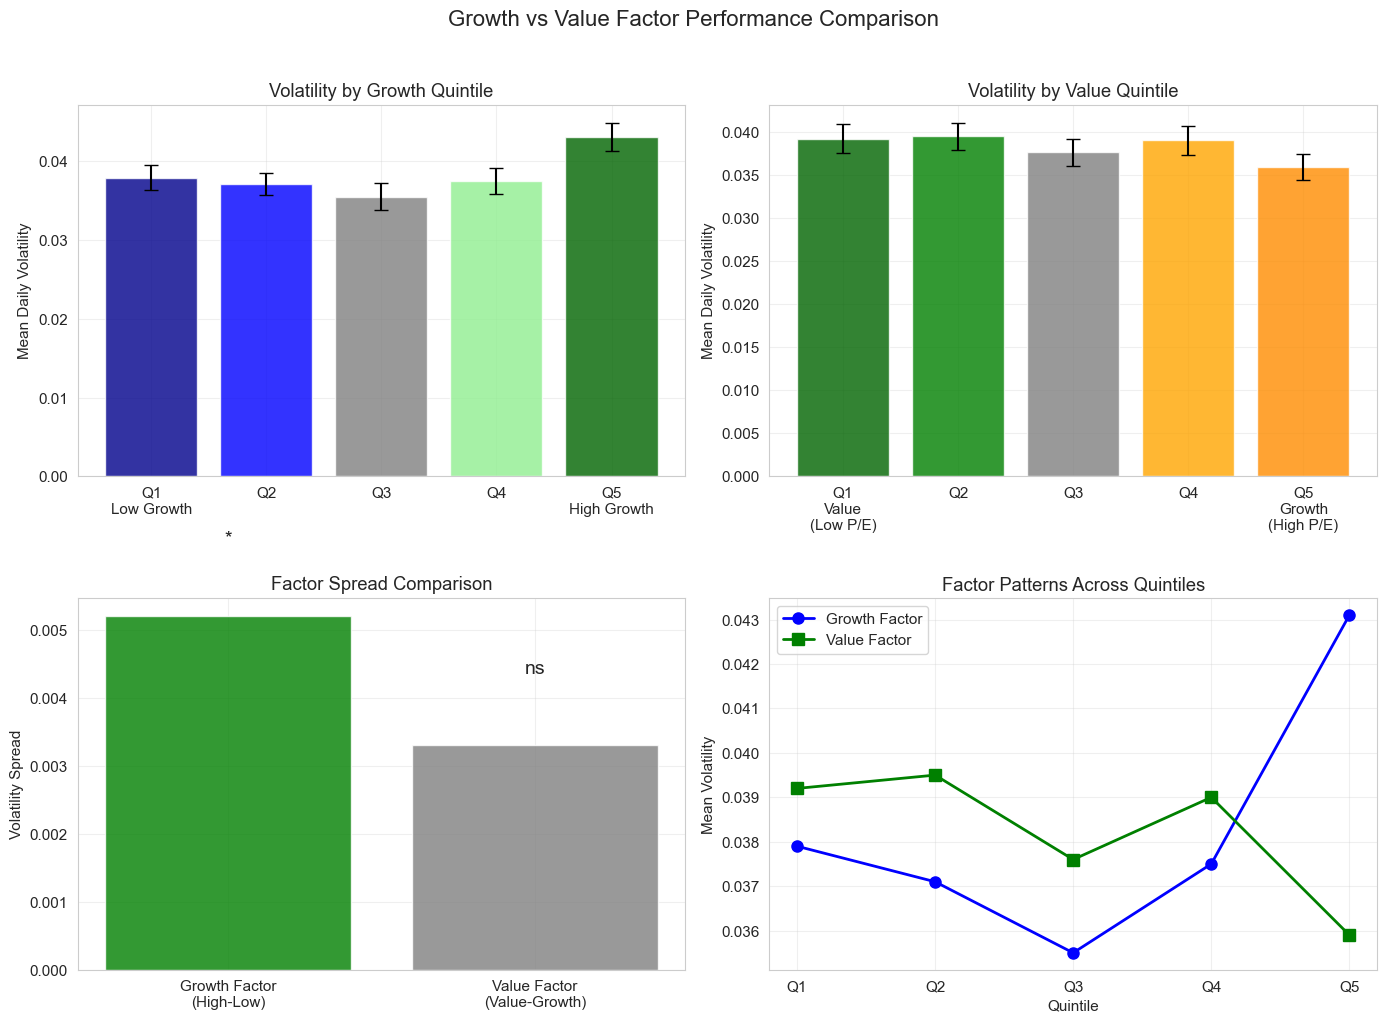


📊 VISUAL ANALYSIS SUMMARY:
Growth factor shows non-monotonic pattern
Value factor shows non-monotonic pattern

Statistical significance (***p<0.001, **p<0.01, *p<0.05, ns=not significant)


In [13]:
# Create comprehensive results visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Growth vs Value Factor Performance Comparison', fontsize=16, y=1.02)

# 1. Growth portfolios bar chart
growth_means = growth_performance['mean']
growth_errors = growth_performance['std_error']
colors_growth = ['darkblue', 'blue', 'gray', 'lightgreen', 'darkgreen']
x_pos = np.arange(len(growth_means))
bars1 = axes[0, 0].bar(x_pos, growth_means, yerr=growth_errors, 
                       capsize=5, alpha=0.8, color=colors_growth)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(['Q1\nLow Growth', 'Q2', 'Q3', 'Q4', 'Q5\nHigh Growth'], rotation=0)
axes[0, 0].set_title('Volatility by Growth Quintile')
axes[0, 0].set_ylabel('Mean Daily Volatility')
axes[0, 0].grid(True, alpha=0.3)

# 2. Value portfolios bar chart
value_means = value_performance['mean']
value_errors = value_performance['std_error']
colors_value = ['darkgreen', 'green', 'gray', 'orange', 'darkorange']
x_pos = np.arange(len(value_means))
bars2 = axes[0, 1].bar(x_pos, value_means, yerr=value_errors, 
                      capsize=5, alpha=0.8, color=colors_value)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['Q1\nValue\n(Low P/E)', 'Q2', 'Q3', 'Q4', 'Q5\nGrowth\n(High P/E)'], rotation=0)
axes[0, 1].set_title('Volatility by Value Quintile')
axes[0, 1].set_ylabel('Mean Daily Volatility')
axes[0, 1].grid(True, alpha=0.3)

# 3. Factor spread comparison
factor_names = ['Growth Factor\n(High-Low)', 'Value Factor\n(Value-Growth)']
factor_spreads = [growth_spread, value_spread]
factor_pvalues = [p_value_growth, p_value_value]
colors_spread = ['green' if p < 0.05 else 'gray' for p in factor_pvalues]

bars3 = axes[1, 0].bar(factor_names, factor_spreads, color=colors_spread, alpha=0.8)
axes[1, 0].set_title('Factor Spread Comparison')
axes[1, 0].set_ylabel('Volatility Spread')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Add significance stars
for i, (bar, p_val) in enumerate(zip(bars3, factor_pvalues)):
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, 
                   height + 0.001 if height > 0 else height - 0.001,
                   sig_text, ha='center', va='bottom' if height > 0 else 'top', fontsize=14)

# 4. Combined line plot
x_labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
axes[1, 1].plot(x_labels, growth_means, marker='o', label='Growth Factor', 
               linewidth=2, markersize=8, color='blue')
axes[1, 1].plot(x_labels, value_means, marker='s', label='Value Factor', 
               linewidth=2, markersize=8, color='green')
axes[1, 1].set_title('Factor Patterns Across Quintiles')
axes[1, 1].set_xlabel('Quintile')
axes[1, 1].set_ylabel('Mean Volatility')
axes[1, 1].legend(loc='best')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 VISUAL ANALYSIS SUMMARY:")
print(f"Growth factor shows {'monotonic' if all(growth_means.diff()[1:] > 0) or all(growth_means.diff()[1:] < 0) else 'non-monotonic'} pattern")
print(f"Value factor shows {'monotonic' if all(value_means.diff()[1:] > 0) or all(value_means.diff()[1:] < 0) else 'non-monotonic'} pattern")
print(f"\nStatistical significance (***p<0.001, **p<0.01, *p<0.05, ns=not significant)")

## Story 1.9: Final Conclusions (10 mins)

In [14]:
print("="*70)
print("   FINAL REPORT: Growth vs Value Factor Analysis")
print("   Using Fundamentals-Only Dataset")
print("="*70)

print("\n📊 1. DATA ANALYSIS (Lectures 1-9)")
print("="*60)
print(f"✓ Analyzed {len(analysis_df)} stocks from Indian market")
print(f"✓ Single dataset approach - simpler and cleaner")
print(f"✓ Created visualizations: distributions, scatter plots, correlations")
print(f"✓ Key insight: {'Positive' if corr_matrix.loc['Earnings_Growth_Q', 'Volatility'] > 0 else 'Negative'} correlation between growth and volatility")

print("\n🎲 2. PROBABILITY MODELING (Lectures 10-18)")
print("="*60)
print(f"✓ Modeled factors as random variables")
print(f"✓ Growth factor: E[G] = {growth_rv.mean():.2%}, σ(G) = {growth_rv.std():.2%}")
print(f"✓ Value factor: E[V] = {value_rv.mean():.2f}, σ(V) = {value_rv.std():.2f}")
print(f"✓ Tested distributions - {'mostly normal' if p_value_growth > 0.05 else 'non-normal'} patterns")

print("\n📈 3. STATISTICAL INFERENCE (Lectures 19-28)")
print("="*60)
print(f"✓ Created quintile portfolios (~{len(analysis_df)//5} stocks each)")
print(f"✓ Growth factor spread: {growth_spread:.4f}")
print(f"✓ Value factor spread: {value_spread:.4f}")
print(f"\nHypothesis Test Results:")
print(f"  • Growth: {'✅ SIGNIFICANT' if p_value_growth < 0.05 else '❌ NOT SIGNIFICANT'} (p={p_value_growth:.6f})")
print(f"  • Value: {'✅ SIGNIFICANT' if p_value_value < 0.05 else '❌ NOT SIGNIFICANT'} (p={p_value_value:.6f})")

print("\n🏆 4. WINNER DETERMINATION")
print("="*60)
if abs(growth_spread) > abs(value_spread):
    print(f"Winner: GROWTH FACTOR")
    print(f"• Growth spread ({abs(growth_spread):.4f}) > Value spread ({abs(value_spread):.4f})")
    if p_value_growth < 0.05:
        print(f"• Statistically significant at 5% level")
    print(f"• Interpretation: High-growth stocks have {'higher' if growth_spread > 0 else 'lower'} volatility")
else:
    print(f"Winner: VALUE FACTOR") 
    print(f"• Value spread ({abs(value_spread):.4f}) > Growth spread ({abs(growth_spread):.4f})")
    if p_value_value < 0.05:
        print(f"• Statistically significant at 5% level")
    print(f"• Interpretation: Value stocks (low P/E) have {'higher' if value_spread > 0 else 'lower'} volatility")

print("\n⚠️ 5. LIMITATIONS")
print("="*60)
print("• Cross-sectional analysis only (single time point)")
print("• Volatility as outcome (not returns)")
print("• No time-series momentum calculation")
print("• Survivorship bias possible")

print("\n🔬 6. ADVANTAGES OF THIS APPROACH")
print("="*60)
print(f"• Much larger sample ({len(analysis_df)} vs 122 stocks)")
print("• Simpler implementation (one dataset)")
print("• No complex merging required")
print("• All data from same source/time")

print("\n📚 7. COURSE CONCEPTS SUCCESSFULLY APPLIED")
print("="*60)
print("Lectures 1-9:  ✓ Data cleaning, visualization, descriptive statistics")
print("Lectures 10-18: ✓ Random variables, distributions, probability")
print("Lectures 19-28: ✓ Sampling, hypothesis testing, confidence intervals")

print("\n" + "="*70)
print("   Analysis Complete - Growth vs Value Using Fundamentals Only")
print("="*70)

   FINAL REPORT: Growth vs Value Factor Analysis
   Using Fundamentals-Only Dataset

📊 1. DATA ANALYSIS (Lectures 1-9)
✓ Analyzed 1102 stocks from Indian market
✓ Single dataset approach - simpler and cleaner
✓ Created visualizations: distributions, scatter plots, correlations
✓ Key insight: Positive correlation between growth and volatility

🎲 2. PROBABILITY MODELING (Lectures 10-18)
✓ Modeled factors as random variables
✓ Growth factor: E[G] = 34.55%, σ(G) = 84.23%
✓ Value factor: E[V] = 31.80, σ(V) = 20.61
✓ Tested distributions - non-normal patterns

📈 3. STATISTICAL INFERENCE (Lectures 19-28)
✓ Created quintile portfolios (~220 stocks each)
✓ Growth factor spread: 0.0052
✓ Value factor spread: 0.0033

Hypothesis Test Results:
  • Growth: ✅ SIGNIFICANT (p=0.029337)
  • Value: ❌ NOT SIGNIFICANT (p=0.148966)

🏆 4. WINNER DETERMINATION
Winner: GROWTH FACTOR
• Growth spread (0.0052) > Value spread (0.0033)
• Statistically significant at 5% level
• Interpretation: High-growth stocks hav